# #30DayMapChallenge
## Day 7: Accessibility

### Data Source
1. Greggs (All in London): https://www.allinlondon.co.uk/directory/store-finders/757-greggs?page=1
2. Greggs (Kaggle): https://www.kaggle.com/datasets/tobynott/greggs-locations-uk?resource=download [not used]

### Useful References
1. Computing Accessibilities (Norman Foster Institute): https://norman-foster-institute.github.io/ua_part1/themes/3_access/amenities.html
2. Cityseer documentation: https://cityseer.benchmarkurbanism.com/intro

### Setup

In [1]:
import pandas as pd
import re
from geopy.geocoders import Nominatim
import time
import folium

In [6]:
# If cannot import modules and system path Kernal is in a custom Anaconda environment (e.g. C:\Users\User\anaconda3\envs\myenv\python.exe)
#import sys
#!{sys.executable} -m pip install osmnx
#!{sys.executable} -m pip install cityseer

In [7]:
# Read the excel file
df = pd.read_excel("Greggs.xlsx")

### Geocoding

In [9]:
# Function to extract postal code using regex
def extract_postcode(address):
    match = re.search(r'[A-Z]{1,2}\d{1,2}[A-Z]?\s?\d[A-Z]{2}', str(address))
    return match.group(0) if match else None

In [10]:
# Extract postal code using regex
df['Postal_Code'] = df['Location'].apply(extract_postcode)

In [11]:
# Function for geocoding
def geocode_postcode(postcode):
    try:
        location = geolocator.geocode(postcode + ", UK")
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        pass
    return pd.Series([None, None])

In [12]:
# Geocode postal codes to coordinates
geolocator = Nominatim(user_agent="greggs_locator")

# Apply geocoding
df[['Latitude', 'Longitude']] = df['Postal_Code'].apply(lambda x: geocode_postcode(x) if pd.notnull(x) else pd.Series([None, None]))

In [13]:
# Remove null values from dataframe
df_cleaned = df.dropna(subset=['Latitude', 'Longitude'])

In [14]:
# Define UK bounding box
uk_lat_min, uk_lat_max = 49.9, 60.9
uk_lon_min, uk_lon_max = -8.6, 1.8

# Filter out points outside UK bounds
df_cleaned = df_cleaned[
    (df_cleaned['Latitude'] >= uk_lat_min) & (df_cleaned['Latitude'] <= uk_lat_max) &
    (df_cleaned['Longitude'] >= uk_lon_min) & (df_cleaned['Longitude'] <= uk_lon_max)
]

In [15]:
# Save clean Gregg data
df_cleaned.to_csv("Greggs_cleaned.csv", index=False)

### Plot Map

In [17]:
# Center the map on the UK
map_center = [51.5074, -0.1278]
greggs_map = folium.Map(location=map_center, zoom_start=10)

# Plot simple red dots for each store
for _, row in df_cleaned.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=3,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7
        ).add_to(greggs_map)

# Display in notebook
greggs_map

### Computing Accessibility using Cityseer

In [3]:
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx
import osmnx as ox
import copy
from cityseer.tools.io import network_structure_from_nx
from shapely.geometry import LineString
import networkx as nx
from shapely.geometry import box
from cityseer.metrics.layers import compute_accessibilities

In [5]:
df_cleaned = pd.read_csv("Greggs_cleaned.csv")

In [7]:
# Convert Greggs data to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_cleaned,
    geometry=gpd.points_from_xy(df_cleaned['Longitude'], df_cleaned['Latitude']),
    crs="EPSG:4326"
)

In [9]:
# Reproject Gregg points to British National Grid
gdf = gdf.to_crs(epsg=27700)

In [11]:
# Get street network for Greater London (if just "London, UK", it will exclude City of London)
G = ox.graph_from_place("Greater London, UK", network_type='walk')

In [12]:
# Make a copy of the street network (in order to preserve G as graph_from_place takes awhile to retrieve the data)
G_copy = copy.deepcopy(G)

In [13]:
# Change projection of graph from 4326 to 27700
G_copy = ox.project_graph(G_copy, to_crs="EPSG:27700")
# Note that G_copy.graph["crs"] = 27700 will not reproject the graph but just edit the metadata

In [14]:
# Remove self-loop edges
G_copy.remove_edges_from([(u, v, k) for u, v, k in G_copy.edges(keys=True) if u == v])

In [15]:
# Ensure graph has a geom attribute
for u, v, k, data in G_copy.edges(keys=True, data=True):
    if 'geom' not in data:
        try:
            x1, y1 = G_copy.nodes[u]['x'], G_copy.nodes[u]['y']
            x2, y2 = G_copy.nodes[v]['x'], G_copy.nodes[v]['y']
            data['geom'] = LineString([(x1, y1), (x2, y2)])
        except KeyError:
            pass  # skip if node coordinates are missing

In [16]:
# Converts all node IDs in your graph G_copy to strings
# Cityseer expects consistent node labels, especially when merging with accessibility scores or land use data
G_copy = nx.relabel_nodes(G_copy, lambda x: str(x))

In [17]:
# Transforms NetworkX graph into GeoPandas format
nodes_gdf, edges_gdf, network_structure = network_structure_from_nx(G_copy)

INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|██████████| 491125/491125 [01:06<00:00, 7362.13it/s] 
INFO:cityseer.graph:Edge R-tree built successfully with 622274 items.


In [18]:
# Get bounding box from nodes_gdf
bounds = nodes_gdf.total_bounds  # [minx, miny, maxx, maxy]
bbox = box(bounds[0], bounds[1], bounds[2], bounds[3])

# Filter Greggs points
gdf_filtered = gdf[gdf.geometry.within(bbox)]

In [19]:
# Make an independent copy before modifying the GeoDataFrame
gdf_filtered = gdf_filtered.copy()
gdf_filtered["landuse"] = "Greggs"

In [20]:
# Compute accessibility
access_df, _ = compute_accessibilities(
    data_gdf=gdf_filtered, 
    landuse_column_label="landuse",
    accessibility_keys=["Greggs"],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=[500, 1000], # adjust for other distances (e.g. 500, 1000, 1500, 2000)
    data_id_col=None
)

INFO:cityseer.metrics.layers:Computing land-use accessibility for: Greggs
INFO:cityseer.metrics.layers:Assigning data to network.
INFO:cityseer.data:Assigning 215 data entries to network nodes (max_dist: 100).
INFO:cityseer.data:Finished assigning data. 387 assignments added to 383 nodes.
100%|██████████| 491125/491125 [39:41<00:00, 206.26it/s]
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 500m, Beta: 0.008, Walking Time: 6.25 minutes.
INFO:cityseer.config:Distance: 1000m, Beta: 0.004, Walking Time: 12.5 minutes.


In [21]:
# Check columns
access_df.columns

Index(['ns_node_idx', 'x', 'y', 'live', 'weight', 'geom', 'cc_Greggs_500_nw',
       'cc_Greggs_500_wt', 'cc_Greggs_1000_nw', 'cc_Greggs_1000_wt',
       'cc_Greggs_nearest_max_1000'],
      dtype='object')

In [22]:
# Assign accessibility scores to edges by averaging the scores of the two connected nodes
# List of accessibility columns to propagate
access_columns = [
    'cc_Greggs_500_nw',
    'cc_Greggs_500_wt',
    'cc_Greggs_1000_nw',
    'cc_Greggs_1000_wt'
]

# Loop through each edge and assign averaged values for each column
for u, v, data in G_copy.edges(data=True):
    for col in access_columns:
        try:
            acc_u = access_df.loc[u, col]
            acc_v = access_df.loc[v, col]
            data[col] = (acc_u + acc_v) / 2
        except KeyError:
            data[col] = None  # Handle missing node data gracefully

In [23]:
# Convert NetworkX graph G_copy into a GeoDataFrame of edges, making it spatially usable for plotting, analysis, and export
edges_gdf = ox.graph_to_gdfs(G_copy, nodes=False, edges=True)

In [24]:
edges_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1259474 entries, ('78112', '25508583', np.int64(0)) to ('13267267634', '13267267632', np.int64(0))
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   osmid              1259474 non-null  object  
 1   access             26834 non-null    object  
 2   highway            1259474 non-null  object  
 3   maxspeed           372734 non-null   object  
 4   name               542224 non-null   object  
 5   oneway             1259474 non-null  bool    
 6   reversed           1259474 non-null  object  
 7   length             1259474 non-null  float64 
 8   geom               1259474 non-null  object  
 9   cc_Greggs_500_nw   1259474 non-null  float32 
 10  cc_Greggs_500_wt   1259474 non-null  float32 
 11  cc_Greggs_1000_nw  1259474 non-null  float32 
 12  cc_Greggs_1000_wt  1259474 non-null  float32 
 13  geometry           1259474 non-null  geo

There are two types of accessibility metrics represented by the nw and wt columns:
- nw (Network Count): This metric reflects the number of stores reachable within a specified network distance (e.g., 500m or 1000m). It is quantity-focused, showing how many amenities are accessible from each edge or road segment.
- wt (Weighted Gravity Score): This metric calculates a proximity-weighted score based on the distance to each reachable store. Closer stores contribute more to the score, making it proximity-focused. It captures not just how many stores are nearby, but how easily they can be reached.

<Axes: >

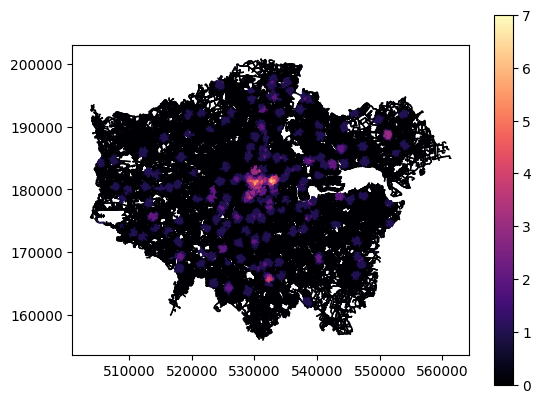

In [25]:
# Plot Network Count for 1000m
edges_gdf.plot(
    column="cc_Greggs_1000_nw",  # cc_Greggs_500_nw; cc_Greggs_500_wt; cc_Greggs_1000_nw; cc_Greggs_1000_wt
    cmap="magma",            # viridis; plasma; coolwarm
    linewidth=1,
    legend=True
)

<Axes: >

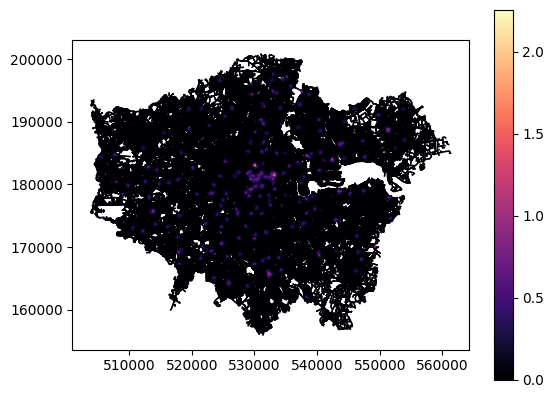

In [26]:
# Plot Weighted Gravity score for 1000m
edges_gdf.plot(
    column="cc_Greggs_1000_wt",  # cc_Greggs_500_nw; cc_Greggs_500_wt; cc_Greggs_1000_nw; cc_Greggs_1000_wt
    cmap="magma",            # viridis; plasma; coolwarm
    linewidth=1,
    legend=True
)

In [27]:
# Adding a geom earlier causes a contradition since there is a geometry column
# Need to drop geom column in order to be able to export the data
edges_gdf = edges_gdf.drop(columns=["geom"], errors="ignore")

In [28]:
# Export the dataset for visualisation in QGIS
edges_gdf.to_file("greggs_accessibility.gpkg", layer="edges", driver="GPKG")

INFO:pyogrio._io:Created 1,259,474 records
